In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pickle

Границы Нью-Йорка

In [4]:
nyc_longitude_west = -74.25559
nyc_longitude_east = -73.70001
nyc_latitude_north = 40.91553
nyc_latitude_south = 40.49612

Загружаем данные за май

In [5]:
with open("./data/2016/05.pkl", "r") as fid:
    data = pickle.load(fid)

Суммируем общее число поездок из каждой географической зоны.

In [6]:
data_reg_aggr = data.sum(axis=1)

Найдем число зон, из которых за май 2016 года не было совершено ни одной поездки.

In [7]:
(data_reg_aggr == 0).sum()

1283

Таким образом, получили, что из 1283 регионов не было поездок в мае 2016 года.

In [8]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

In [9]:
regions = pd.read_csv("regions.csv", sep=";")
regions.head()

region      west       east      south      north
0       1 -74.25559 -74.244478  40.496120  40.504508
1       2 -74.25559 -74.244478  40.504508  40.512896
2       3 -74.25559 -74.244478  40.512896  40.521285
3       4 -74.25559 -74.244478  40.521285  40.529673
4       5 -74.25559 -74.244478  40.529673  40.538061

In [10]:
longs = np.unique(regions[['west', 'east']].values)
lats = np.unique(regions[['south', 'north']].values)
lon, lat = np.meshgrid(longs, lats)

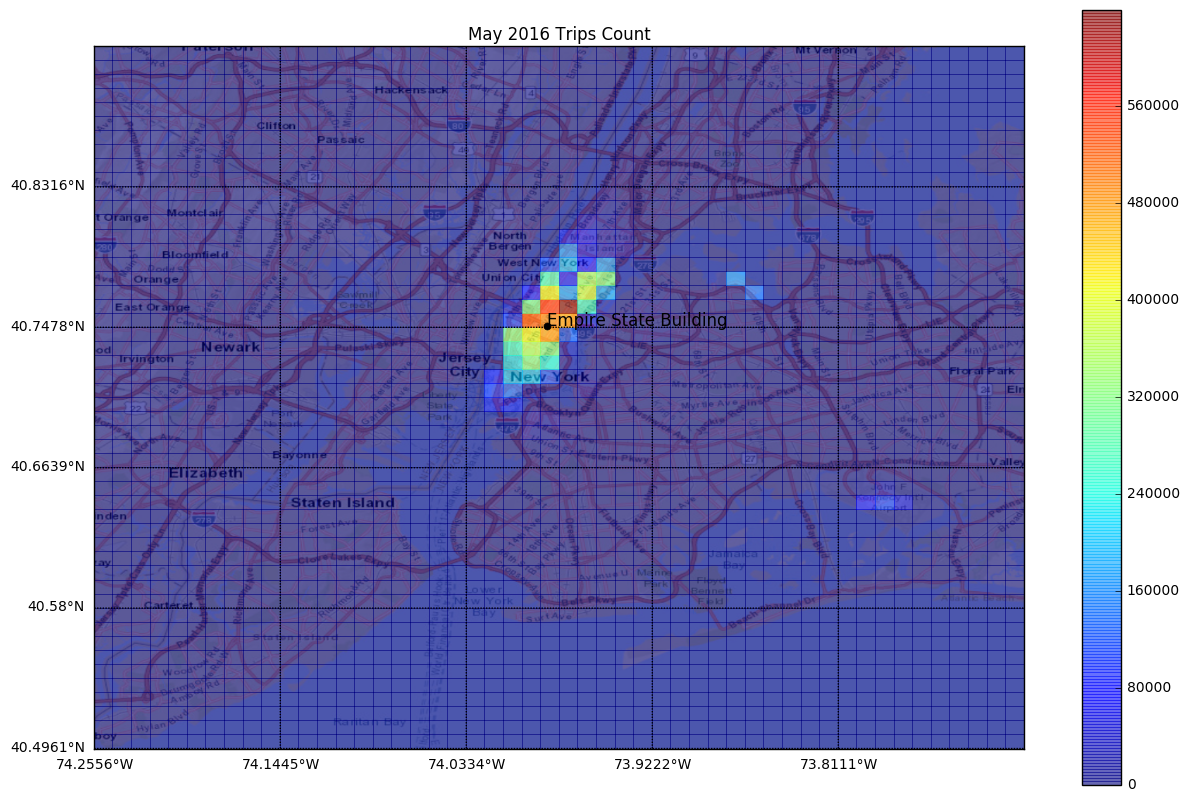

In [15]:
plt.figure(figsize=(15, 10))
ny_map = Basemap(llcrnrlat= nyc_latitude_south, llcrnrlon= nyc_longitude_west, 
                 urcrnrlat= nyc_latitude_north, urcrnrlon= nyc_longitude_east,
                 resolution='f', projection='lcc',
                 lat_0 = (nyc_latitude_north + nyc_latitude_north)/2.0,
                 lon_0 = (nyc_longitude_west + nyc_longitude_east)/2.0, epsg=4326)

#ny_map.shadedrelief(scale=0.5)

ny_map.pcolormesh(lon, lat, data_reg_aggr.reshape(50,50).transpose(), latlon=True, cmap= 'jet', alpha = 0.6)
plt.colorbar()
#plt.clim(-8, 8)
#ny_map.drawcoastlines(color='lightblue')

x, y = ny_map(-73.985428, 40.748817)
plt.plot(x, y, 'ok', markersize=5)
plt.text(x, y, 'Empire State Building', fontsize=12);

#ny_map.drawcoastlines()
#ny_map.drawcountries()
#ny_map.fillcontinents(color='ivory', alpha = 0.5)
ny_map.arcgisimage(service='World_Street_Map', xpixels=1200, epsg=4269)
#ny_map.drawmapboundary()

parallels = np.arange(nyc_latitude_south,nyc_latitude_north, (nyc_latitude_north - nyc_latitude_south)/5)
ny_map.drawparallels(parallels,labels=[True,False,True,False])
meridians = np.arange(nyc_longitude_west,nyc_longitude_east, (nyc_longitude_east - nyc_longitude_west)/5)
ny_map.drawmeridians(meridians,labels=[True,False,False,True])

plt.title('May 2016 Trips Count')

Географическое положение Статуи Свободы взято из http://www.latlong.net/place/statue-of-liberty-national-monument-new-york-usa-2122.html .

In [11]:
lib_st_long = -74.044502
lib_st_lat = 40.689247

Найдем среднее за месяц количество поездок в каждой ячейке.

In [12]:
data_reg_mean = data.mean(axis=1)

In [13]:
import geojson
import json

import folium
from folium import plugins

In [14]:
list_of_features = []
for ind in regions.index:
    poly = geojson.Polygon([[[regions.iloc[ind].west, regions.iloc[ind].south], 
                             [regions.iloc[ind].west, regions.iloc[ind].north],
                             [regions.iloc[ind].east, regions.iloc[ind].north], 
                             [regions.iloc[ind].east, regions.iloc[ind].south],
                             [regions.iloc[ind].west, regions.iloc[ind].south]]])
    feature = geojson.Feature(geometry=poly, id=str(ind), properties={"name": "reg. {}".format(int(regions.iloc[ind].region))})
    list_of_features.append(feature)
features = geojson.FeatureCollection(list_of_features)
with open("regions.json", "w") as fid:
    json.dump(features, fid)

In [15]:
import branca.colormap as cm

In [16]:
vmin = data_reg_mean.min()
vmax = data_reg_mean.max()
width = vmax - vmin
color_func = cm.LinearColormap(['white', 'green', 'cyan', 'blue', 'magenta', 'red'],
                               vmax = vmax, vmin = vmin,
                               index=[vmin, 20, 0.3*width, 0.6*width, 0.9*width, 1.0*vmax])
color_func

In [17]:
map_nyc = folium.Map(location=[(nyc_latitude_south+nyc_latitude_north)/2, (nyc_longitude_east+nyc_longitude_west)/2],
                     zoom_start = 10, tiles= 'cartodbpositron')

folium.Marker([40.748817, -73.985428], popup='Empire State Building').add_to(map_nyc)
folium.Marker([lib_st_lat, lib_st_long], popup='Statue of Liberty').add_to(map_nyc)
folium.Marker([40.6435529, -73.78211390000001], popup= 'New York John F. Kennedy International Airport').add_to(map_nyc)
folium.Marker([40.7769271, -73.87396590000003], popup= 'LaGuardia Airport').add_to(map_nyc)

folium.GeoJson(
    features,
    style_function=lambda feature: {
        'fillColor': color_func(data_reg_mean[int(feature['id'])]),
        'color': 'black',
        'weight': 0.2,
        'dashArray': '5, 5'
    }
).add_to(map_nyc)

color_func.caption = "Mean value of trips"
map_nyc.add_child(color_func)

map_nyc

Теперь отсеим регионы, из которых в среднем в час совершалось меньше 5 поездок. Подсчитаем число таких регионов.

In [19]:
(data_reg_mean < 5).sum()

2398

Таких регионов большинство. Найдем число оставшихся регионов, и изобразим их на карте зеленым цветом, а другие регионы - красным цветом. Проверим, что среди зеленых регионов нет таких, из которых поездки невозможны.

In [20]:
regions_left = []
for ind, val in enumerate(data_reg_mean):
    if val >= 5:
        regions_left.append(int(ind))
print "Число оставшихся регионов: %d" % len(regions_left)

Число оставшихся регионов: 102


In [21]:
def custom_color_map(value):
    global regions_left
    if value in regions_left:
        return '#008000'
    else:
        return '#ff0000'

In [22]:
map_nyc_2 = folium.Map(location=[(nyc_latitude_south+nyc_latitude_north)/2, (nyc_longitude_east+nyc_longitude_west)/2],
                     zoom_start = 10, tiles= "Stamen Terrain")

folium.Marker([40.748817, -73.985428], popup='Empire State Building''Statue of Liberty').add_to(map_nyc_2)
folium.Marker([lib_st_lat, lib_st_long], popup= 'Statue of Liberty').add_to(map_nyc_2)

folium.GeoJson(
    features,
    style_function=lambda feature: {
        'fillColor': custom_color_map(int(feature['id'])),
        'color': 'black',
        'weight': 0.2,
        'dashArray': '5, 5'
    }
).add_to(map_nyc_2)

#color_func.caption = "Mean value of trips"
#map_nyc.add_child(color_func)

map_nyc_2

На карте видим, что среди оставшихся регионов действительно нет тех, из которых поездки невозможны.